In [2]:
import os
from os.path import abspath, join, basename
import pandas as pd
import numpy as np
import datatable as dt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from pathlib import Path

In [3]:
# Set working directory
os.chdir(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
print(f"Current working directory = {os.getcwd()}")

Current working directory = C:\Users\darkg\PycharmProjects\ny_metastasis


In [4]:
# Import local libraries
from src.plot_centroids import plot_centroids
from src.read_marker import read_marker
from src.plot_marker_intensity import plot_marker_intensity
from src.measure_marker_positive_mean_distance import measure_marker_positive_mean_distance
from src.read_markers_labeled import read_markers_labeled
from src.plot_distributions import plot_distributions, plot_distribution_boxen
from src.get_marker_intensities import get_marker_intensities
from src.get_marker_positive_cells import get_marker_positive_cells
from src.plot_sample_distributions import plot_sample_distributions
from src.plot_cell_contours_plotly import plot_cell_contours_plotly
from src.count_marker_positive_neighborhood import count_marker_positive_neighborhood

## Set paths

In [5]:
# Pathways to metadata and data
folder_path = abspath("./data/mcmicro_quants")
metadata_path = abspath("./data/metadata.csv")
image_raw_path = abspath("./data/cell.tif")
image_mask_path = abspath("./data/cell2_mask.tif")
image_quants_path = abspath("./data/mcmicro_quants/mesmer-N-2016-2156-1_hBN220215_16738-35540_cell.csv")

## Set Plot style

In [6]:
# Set palette
sns.set_style("darkgrid")
palette = {"MBM":"#A80D11",
           "ECM":"#008DB8"}

In [7]:
# Read in metadata, set file name as index
metadata = pd.read_csv(metadata_path, index_col="file")
metadata.head()

,sample,source,n,tissue
file,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM


In [8]:
# Get total number of identified cells
print(f"Total number of cells = {metadata['n'].sum()}")

Total number of cells = 8941675


In [9]:
#Get number of cells per tissue
for g, d in metadata.groupby("tissue"):
    print(f"#  Cells in {g} = {d['n'].sum()}")
    print(f"Fraction in {g} = {d['n'].sum()/metadata['n'].sum():.4f}")

#  Cells in ECM = 5352494
Fraction in ECM = 0.5986
#  Cells in MBM = 3589181
Fraction in MBM = 0.4014


## Load raw data

In [10]:
%%time
# Iterate over the results folder and load a dataframe for each file
dfs = list()
for f in os.listdir(folder_path):
    data = pd.read_csv(join(folder_path, f), usecols=["NCAM1", "SOX10"])
    data["tissue"] = "MBM" if f.startswith("mesmer-N") else "ECM"
    data["sample"] = metadata.loc[f]["sample"]
    dfs.append(data)

# Concatenate all dataframes together
all_images = pd.concat(dfs)
all_images = all_images.reset_index(drop=True)
del(dfs)
all_images = all_images.sort_values(by="tissue", ascending=False)
all_images.head()

CPU times: total: 28.1 s
Wall time: 35.7 s


,NCAM1,SOX10,tissue,sample
8941674,1.815220,1.070297,MBM,N-2020-845_Restain_hBN220216
6548882,0.411340,1.242682,MBM,N-2017-1414-1_Restain_hBN220216
6548893,0.204677,0.388484,MBM,N-2017-1414-1_Restain_hBN220216
6548892,0.224390,0.360192,MBM,N-2017-1414-1_Restain_hBN220216
6548891,0.227392,0.898182,MBM,N-2017-1414-1_Restain_hBN220216


## Raw data

CPU times: total: 3min 38s
Wall time: 3min 48s


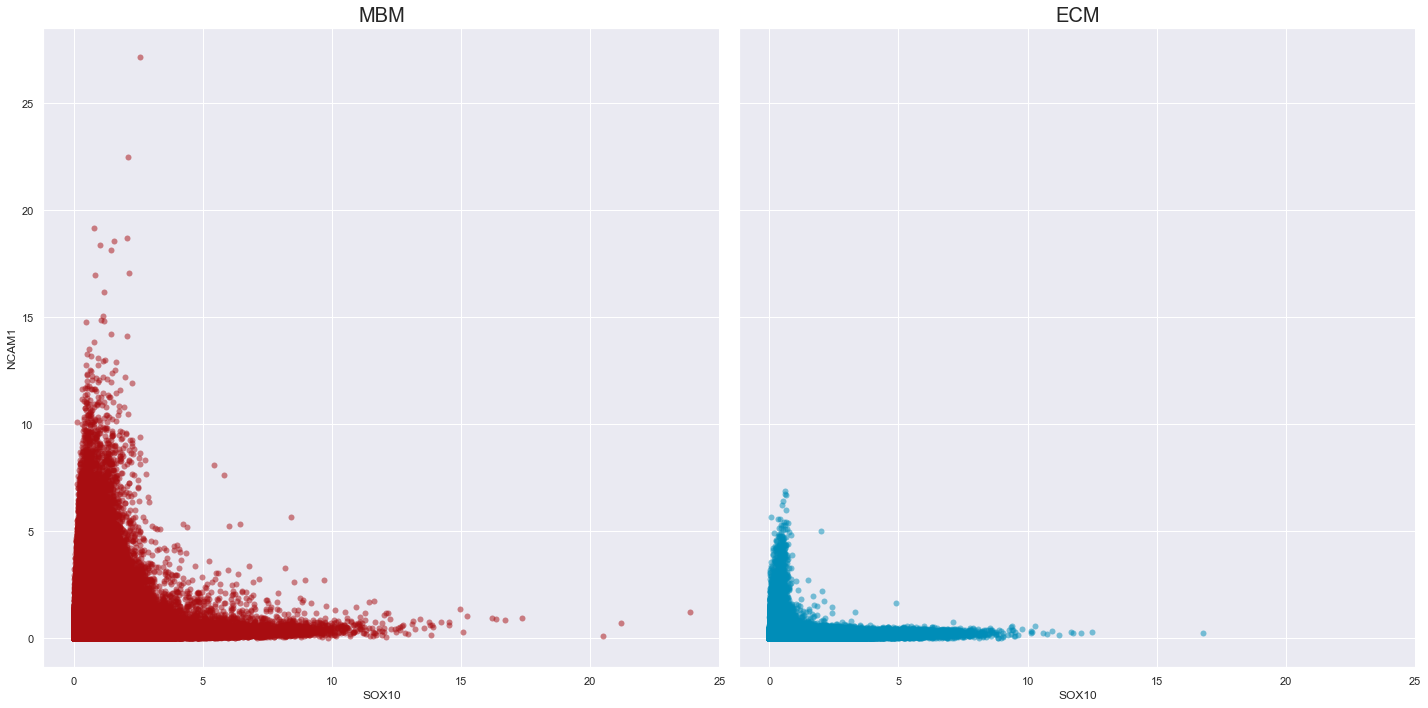

In [11]:
%%time
# Set style
sns.set_theme(style="darkgrid")

# Create canvas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

# Plot left scatter plot for brain
sns.scatterplot(data=all_images[all_images["tissue"]=="MBM"], x="SOX10", y="NCAM1", alpha=0.5, linewidth=0, color=palette["MBM"], rasterized=True, ax=ax1)
ax1.set_title("MBM", fontsize=20)

# Plot right scatter plot for liver
sns.scatterplot(data=all_images[all_images["tissue"]=="ECM"], x="SOX10", y="NCAM1", alpha=0.5, linewidth=0, color=palette["ECM"], rasterized=True, ax=ax2)
ax2.set_title("ECM", fontsize=20)

# Save plot
plt.tight_layout()
plt.savefig(abspath("./out/mets-scatter_SOX10_NCAM1-split_by_tissue-linear.pdf"), dpi=300)
plt.savefig(abspath("./out/mets-scatter_SOX10_NCAM1-split_by_tissue-linear.png"), dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\darkg\\PycharmProjects\\out\\mets-scatter_SOX10_NCAM1-color_by_tissue-raw.pdf'

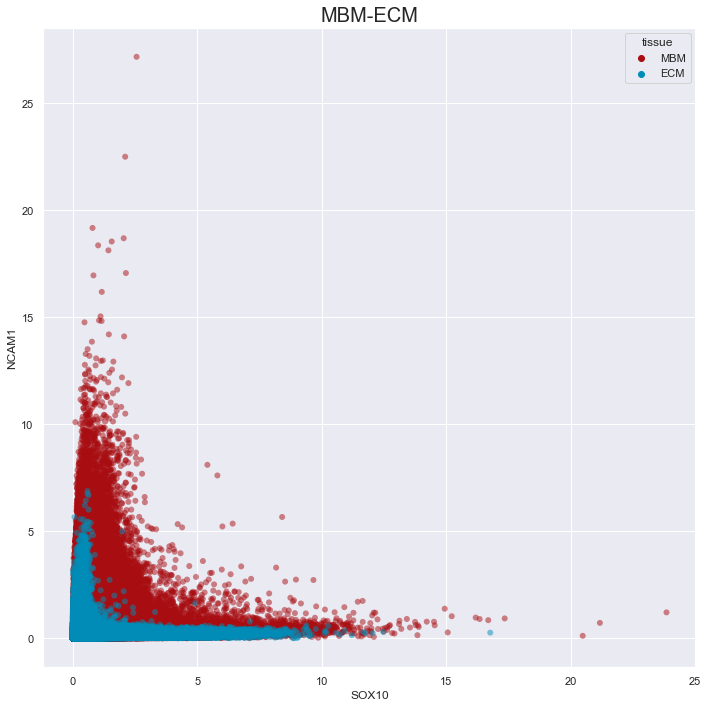

In [12]:
%%time
# Scatterplot of liver and brain samples combined
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=all_images.sort_values(by="tissue", ascending=False), x="SOX10", y="NCAM1", hue="tissue", alpha=0.5, linewidth=0, palette=palette, rasterized=True, ax=ax)
ax.set_title("MBM-ECM", fontsize=20)
plt.tight_layout()
plt.savefig(abspath("./out/mets-scatter_SOX10_NCAM1-color_by_tissue-linear.pdf"), dpi=300)
plt.savefig(abspath("./out/mets-scatter_SOX10_NCAM1-color_by_tissue-linear.png"), dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\darkg\\PycharmProjects\\out\\mets-violin_SOX10_NCAM1-color_by_tissue-raw.pdf'

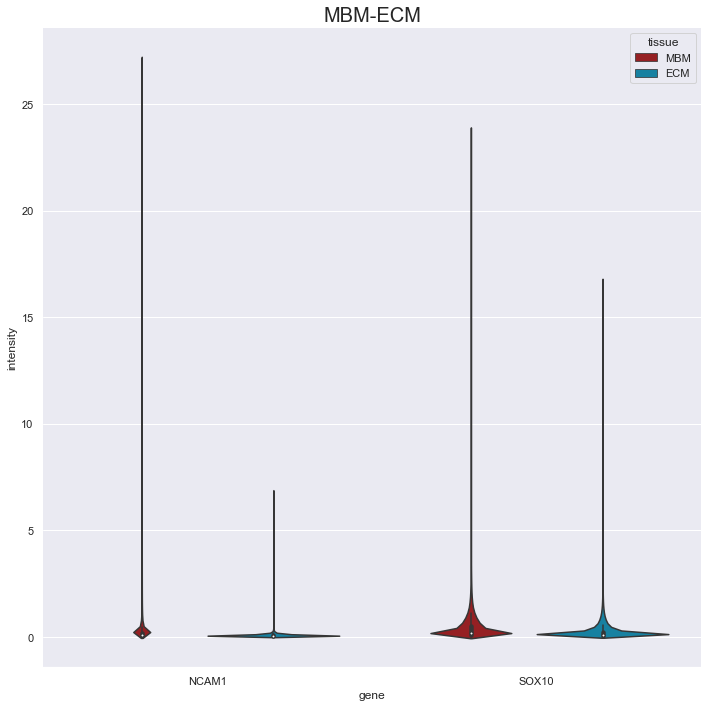

In [13]:
%%time
# Plot violin plot for raw data
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
all_long = all_images.melt(id_vars=["tissue", "sample"], var_name="gene", value_name="intensity")
sns.violinplot(data=all_long, x="gene", y="intensity", hue="tissue", palette=palette, ax=ax)
ax.set_title("MBM-ECM", fontsize=20)
sns.despine(left=True)
plt.tight_layout()
fig.savefig(abspath("./out/mets-violin_SOX10_NCAM1-color_by_tissue-linear.pdf"), dpi=300)
fig.savefig(abspath("./out/mets-violin_SOX10_NCAM1-color_by_tissue-linear.png"), dpi=300)

## Raw data gateing  on SOX10

In [11]:
# Get total number of SOX10 positive cells by tissue
sox10_pos = all_images[all_images["SOX10"]>=1]
gate_sox10 = sox10_pos["tissue"].value_counts()
gate_sox10

MBM    364879
ECM    197268
Name: tissue, dtype: int64

In [12]:
# Portion of SOX10 positive cells by tissue
gate_sox10/gate_sox10.sum()

MBM    0.649081
ECM    0.350919
Name: tissue, dtype: float64

In [13]:
cutoff_sox10 = 1
cutoff_ncam1 = 1

CPU times: total: 9min 28s
Wall time: 9min 32s


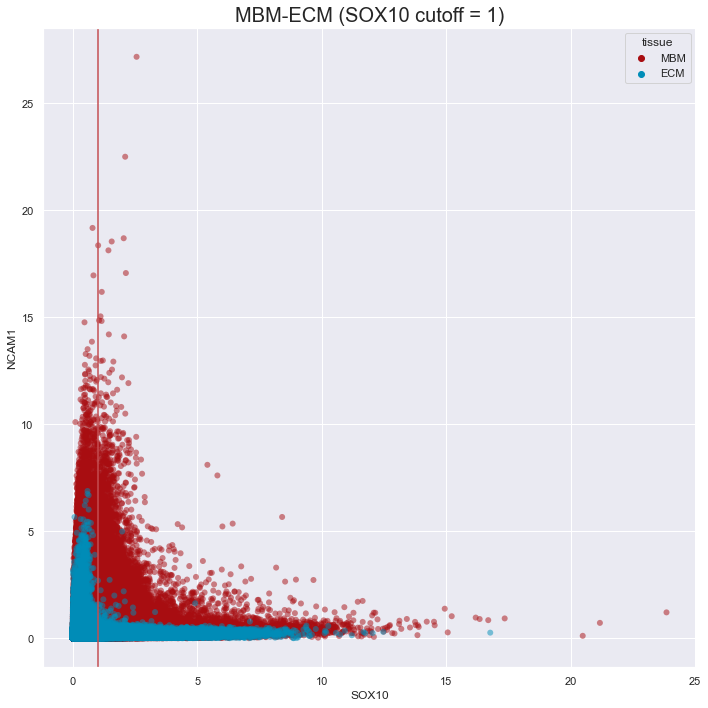

In [13]:
%%time
# Scatterplot of liver and brain samples combined
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=all_images.sort_values(by="tissue", ascending=False), x="SOX10", y="NCAM1", hue="tissue", alpha=0.5, linewidth=0, palette=palette, rasterized=True, ax=ax)
ax.set_title("MBM-ECM (SOX10 cutoff = 1)", fontsize=20)
ax.axvline(1, 0, 1, color="r")
plt.tight_layout()
plt.savefig(abspath("../out/mets-scatter_sox10_ncam1-color_MBM_ECM-vline_sox10pos-raw.pdf"), dpi=300)
plt.savefig(abspath("../out/mets-scatter_sox10_ncam1-color_MBM_ECM-vline_sox10pos-raw.png"), dpi=300)

CPU times: total: 9min 47s
Wall time: 10min 11s


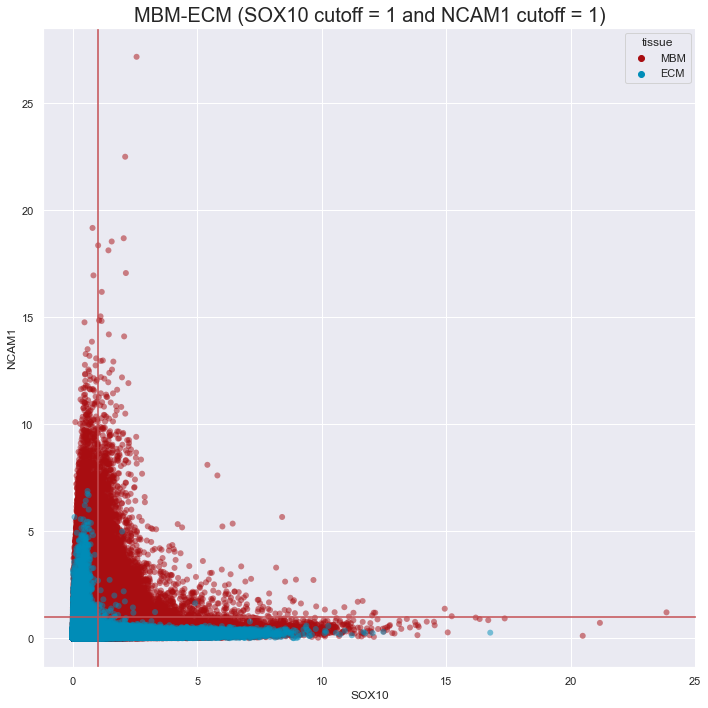

In [14]:
%%time
# Scatter plot of liver and brain samples combined
# For NCAM1 and SOX10 positive
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=all_images.sort_values(by="tissue", ascending=False), x="SOX10", y="NCAM1", hue="tissue", alpha=0.5, linewidth=0, palette=palette, rasterized=True, ax=ax)
ax.set_title("MBM-ECM (SOX10 cutoff = 1 and NCAM1 cutoff = 1)", fontsize=20)
ax.axvline(1, 0, 1, color="r")
ax.axhline(1, 0, 1, color="r")
plt.tight_layout()
plt.savefig(abspath("../out/mets-scatter_SOX10_NCAM1-color_by_tissue-vline_sox10pos-hline_ncam1pos-raw.pdf"), dpi=300)
plt.savefig(abspath("../out/mets-scatter_SOX10_NCAM1-color_by_tissue-vline_sox10pos-hline_ncam1pos-raw.png"), dpi=300)

In [14]:
# Get total number of SOX10 positive cells by tissue
sox10_neg = all_images[all_images["SOX10"]<1]
gate_neg = sox10_neg["tissue"].value_counts()
gate_neg

ECM    5155226
MBM    3224302
Name: tissue, dtype: int64

In [15]:
# Portion of SOX10 negative cells by tissue
gate_neg/gate_neg.sum()

ECM    0.615217
MBM    0.384783
Name: tissue, dtype: float64

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\darkg\\PycharmProjects\\out\\mets-violin_SOX10_NCAM1-color_by_tissue-SOX10neg-raw.pdf'

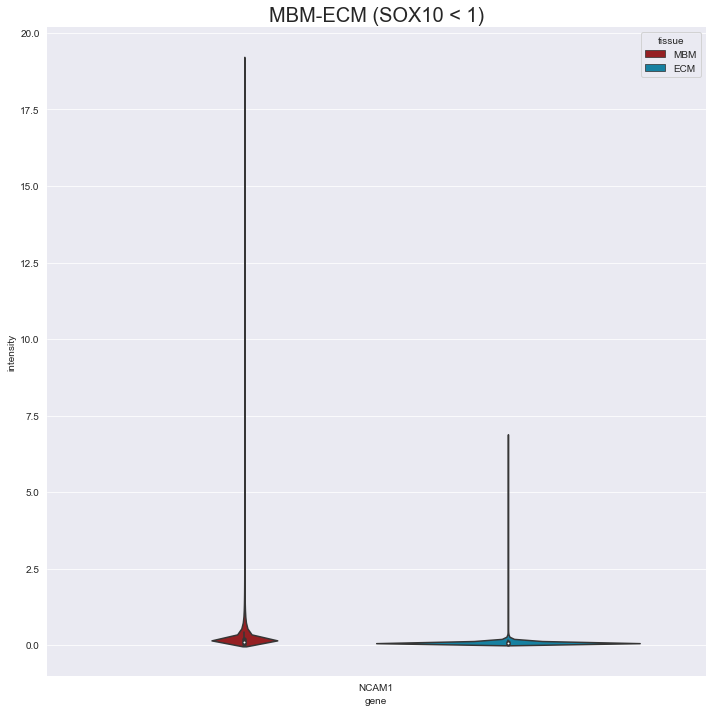

In [20]:
%%time
# Plot violin plot for gated sox10 negative
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sox10_neg_long = sox10_neg.melt(id_vars=["tissue", "sample"], var_name="gene", value_name="intensity")
sox10_neg_long = sox10_neg_long.sort_values(by="tissue", ascending=False)
sns.violinplot(data=sox10_neg_long[sox10_neg_long["gene"]=="NCAM1"], x="gene", y="intensity", palette=palette, hue="tissue", ax=ax)
ax.set_title("MBM-ECM (SOX10 < 1)", fontsize=20)
sns.despine(left=True)
plt.tight_layout()
fig.savefig(abspath("./out/mets-violin_SOX10_NCAM1-color_by_tissue-SOX10neg-raw.pdf"), dpi=300)
fig.savefig(abspath("./out/mets-violin_SOX10_NCAM1-color_by_tissue-SOX10neg-raw.png"), dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\darkg\\PycharmProjects\\out\\mets-violin_SOX10_NCAM1-color_by_tissue-SOX10pos-raw.pdf'

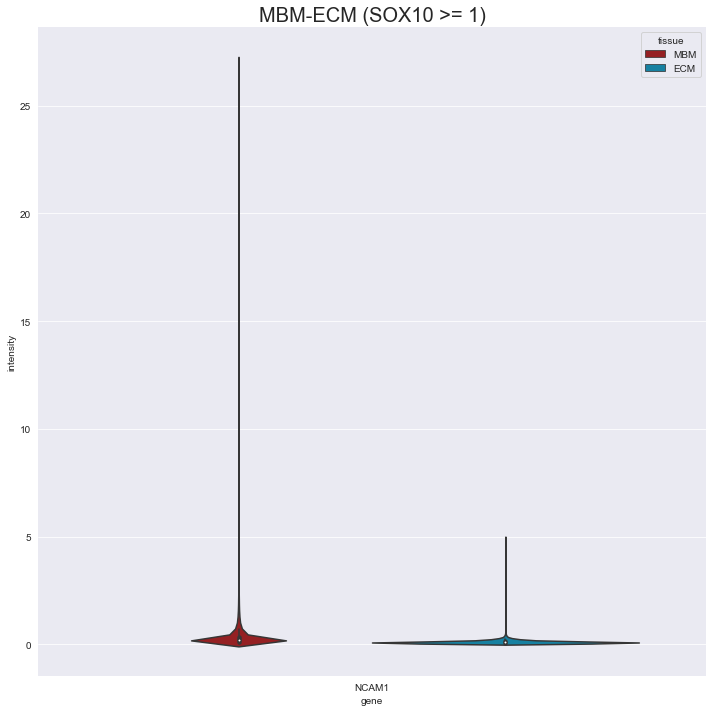

In [21]:
%%time
# Plot violin plot for gated sox10 positive
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sox10_pos_long = sox10_pos.melt(id_vars=["tissue", "sample"], var_name="gene", value_name="intensity")
sox10_pos_long = sox10_pos_long.sort_values(by="tissue", ascending=False)
sns.violinplot(data=sox10_pos_long[sox10_pos_long["gene"]=="NCAM1"], x="gene", y="intensity", palette=palette, hue="tissue", ax=ax)
ax.set_title("MBM-ECM (SOX10 >= 1)", fontsize=20)
sns.despine(left=True)
plt.tight_layout()
fig.savefig(abspath("./out/mets-violin_SOX10_NCAM1-color_by_tissue-SOX10pos-raw.pdf"), dpi=300)
fig.savefig(abspath("./out/mets-violin_SOX10_NCAM1-color_by_tissue-SOX10pos-raw.png"), dpi=300)

### SOX10 positive

In [16]:
for g, df  in sox10_pos.groupby("tissue"):
    print(g,f'Mean = {df["NCAM1"].mean()}')
    print(g,f'Std  = {df["NCAM1"].std()}')

ECM Mean = 0.11134277369628931
ECM Std  = 0.07285387397278457
MBM Mean = 0.3520803622090947
MBM Std  = 0.5803476273037537


### SOX10 negative

In [17]:
for g, df  in sox10_neg.groupby("tissue"):
    print(g,f'Mean = {df["NCAM1"].mean()}')
    print(g,f'Std  = {df["NCAM1"].std()}')

ECM Mean = 0.06682517114802537
ECM Std  = 0.07018416870892928
MBM Mean = 0.20135732906145076
MBM Std  = 0.40357061589036297


### Wilcoxon test

In [18]:
%%time
# Get Wilcoxon ranked sum tes to check the difference between
res = ranksums(sox10_pos["NCAM1"], sox10_neg["NCAM1"], alternative="two-sided")
res

CPU times: total: 3.12 s
Wall time: 3.67 s


RanksumsResult(statistic=634.9346052321325, pvalue=0.0)

In [19]:
%%time
res = ranksums(sox10_pos["NCAM1"], sox10_neg["NCAM1"], alternative="greater")
res

CPU times: total: 2.44 s
Wall time: 2.44 s


RanksumsResult(statistic=634.9346052321325, pvalue=0.0)

## Log transform the data

In [20]:
# Log scale the data
scaled = np.log(all_images[["SOX10", "NCAM1"]])
scaled = pd.DataFrame(scaled, columns=["SOX10", "NCAM1"])
scaled["tissue"] = all_images["tissue"]
scaled["sample"] = all_images["sample"]
scaled = scaled.sort_values(by="tissue", ascending=False)
scaled.head()

C:\Users\darkg\PycharmProjects\sandbox\venv\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,SOX10,NCAM1,tissue,sample
8941674,0.067937,0.596207,MBM,N-2020-845_Restain_hBN220216
8941665,-0.249116,0.358364,MBM,N-2020-845_Restain_hBN220216
8941648,0.195799,0.744459,MBM,N-2020-845_Restain_hBN220216
8941649,-0.195422,0.350196,MBM,N-2020-845_Restain_hBN220216
8941650,0.081309,-0.057328,MBM,N-2020-845_Restain_hBN220216


In [21]:
# Remove -inf
scaled_cleaned = scaled[~((scaled["SOX10"] == np.NINF) | (scaled["NCAM1"] == np.NINF))]

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\darkg\\PycharmProjects\\out\\mets-scatter_sox10_ncam1-split_MBM_ECM-log.pdf'

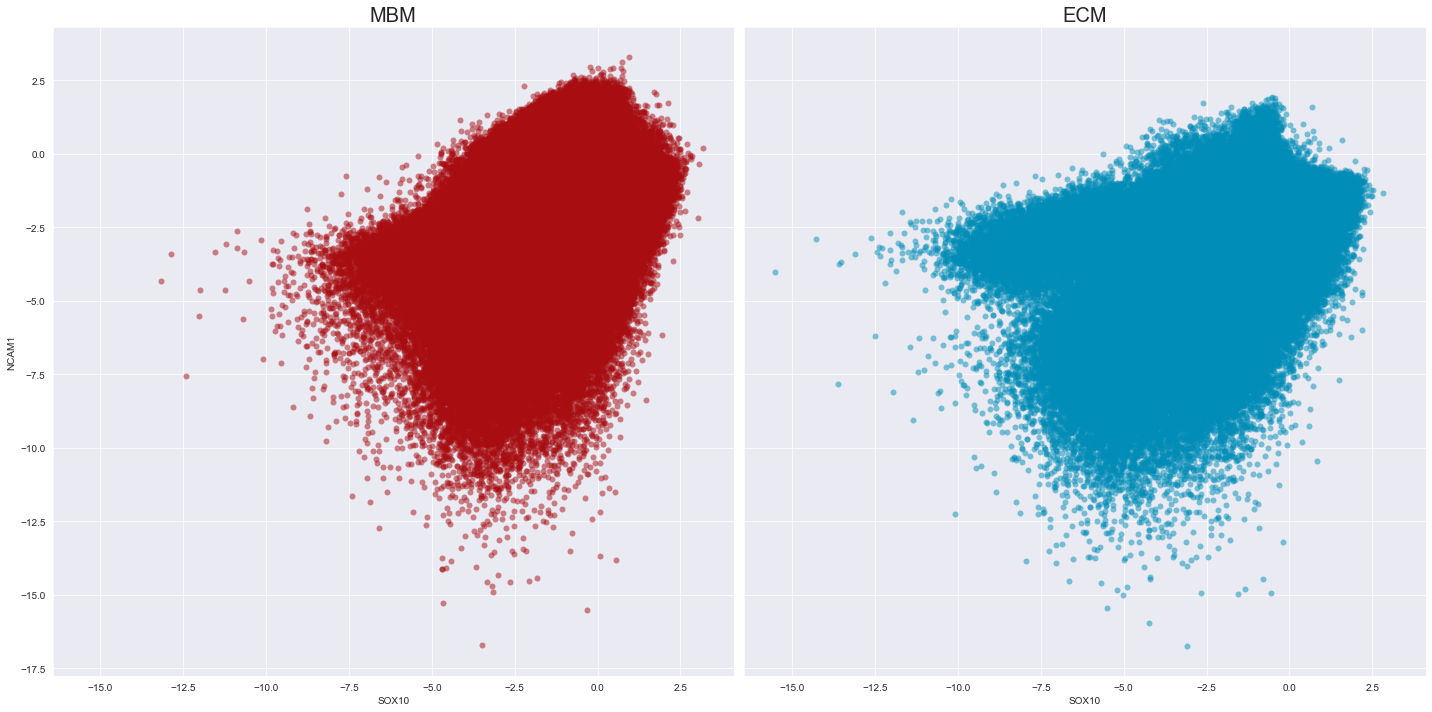

In [13]:
%%time
sns.set_style(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

sns.scatterplot(data=scaled_cleaned[scaled_cleaned["tissue"]=="MBM"], x="SOX10", y="NCAM1", alpha=0.5, linewidth=0, color=palette["MBM"], rasterized=True, ax=ax1)
ax1.set_title("MBM", fontsize=20)

sns.scatterplot(data=scaled_cleaned[scaled_cleaned["tissue"]=="ECM"], x="SOX10", y="NCAM1", alpha=0.5, linewidth=0, color=palette["ECM"], rasterized=True, ax=ax2)
ax2.set_title("ECM", fontsize=20)

plt.tight_layout()
plt.savefig(abspath("./out/mets-scatter_SOX10_NCAM1-split_by_tissue-log.pdf"), dpi=300)
plt.savefig(abspath("./out/mets-scatter_SOX10_NCAM1-split_by_tissue-log.png"), dpi=300)

CPU times: total: 2min 6s
Wall time: 2min 8s


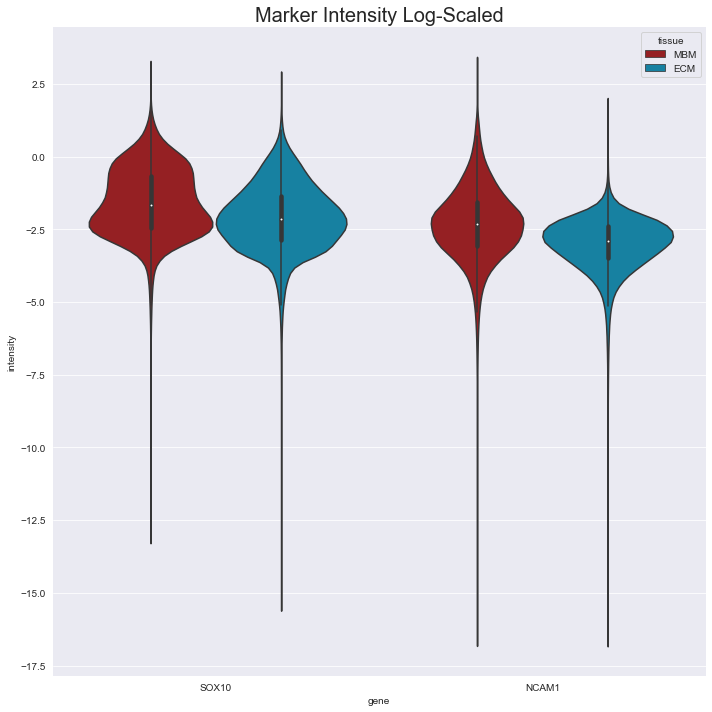

In [22]:
%%time
# Plot violin plot for raw data
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
scale_long = scaled_cleaned.melt(id_vars=["tissue", "sample"], var_name="gene", value_name="intensity")
scale_long = scale_long.sort_values(by="tissue", ascending=False)
sns.violinplot(data=scale_long, x="gene", y="intensity", hue="tissue", palette=palette, ax=ax)
ax.set_title("Marker Intensity Log-Scaled", fontsize=20)
sns.despine(left=True)

plt.tight_layout()
fig.savefig(abspath("./out/mets-violin_SOX10_NCAM1-color_by_tissue-log.pdf"), dpi=300)
fig.savefig(abspath("./out/mets-violin_SOX10_NCAM1-color_by_tissue-log.png"), dpi=300)

CPU times: total: 8min 55s
Wall time: 9min 2s


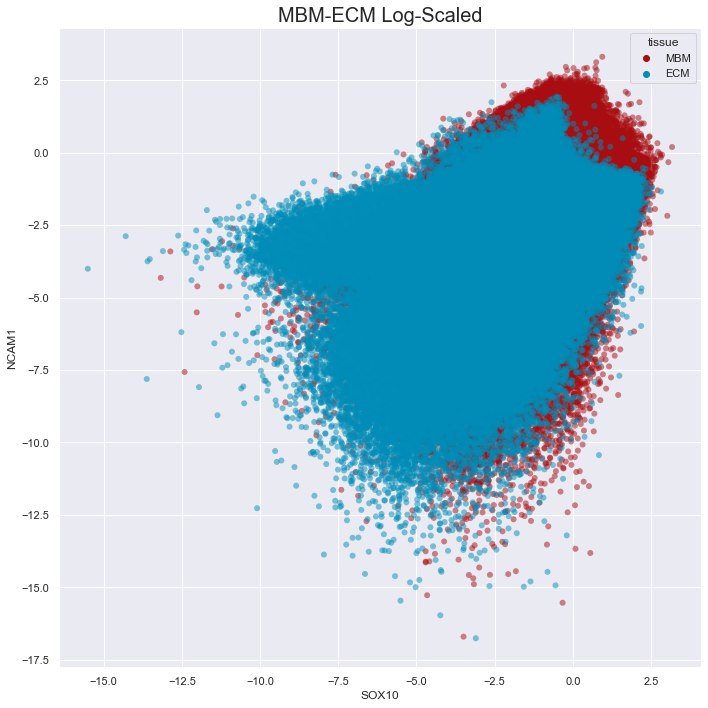

In [36]:
%%time
# Plot scatter plot colored by tissue
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=scaled_cleaned.sort_values(by="tissue", ascending=False), x="SOX10", y="NCAM1", hue="tissue", alpha=0.5, linewidth=0, palette=palette, rasterized=True, ax=ax)
ax.set_title("MBM-ECM Log-Scaled", fontsize=20)
plt.tight_layout()

plt.savefig(abspath("../out/mets-scatter_sox10_ncam1-join_MBM_ECM-log.pdf"), dpi=300)
plt.savefig(abspath("../out/mets-scatter_sox10_ncam1-join_MBM_ECM-log.png"), dpi=300)

CPU times: total: 9min 20s
Wall time: 9min 28s


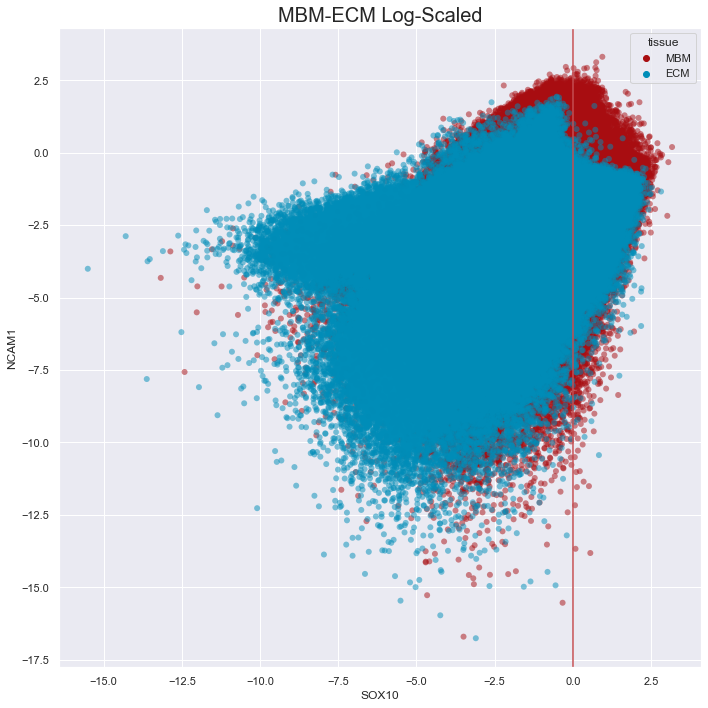

In [37]:
%%time
# Plot scatter plot colored by tissue
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=scaled_cleaned.sort_values(by="tissue", ascending=False), x="SOX10", y="NCAM1", hue="tissue", alpha=0.5, linewidth=0, palette=palette, rasterized=True, ax=ax)
ax.set_title("MBM-ECM Log-Scaled", fontsize=20)
ax.axvline(0, 0, 1, color="r")

plt.tight_layout()

plt.savefig(abspath("../out/mets-scatter_sox10_ncam1-join_MBM_ECM-log-cutoff.pdf"), dpi=300)
plt.savefig(abspath("../out/mets-scatter_sox10_ncam1-join_MBM_ECM-log-cutoff.png"), dpi=300)

In [23]:
# Get total number of SOX10 positive cells by tissue
sox10_pos_log = scaled_cleaned[scaled_cleaned["SOX10"]>=0]
sox10_pos_log.shape

(561848, 4)

CPU times: total: 4.27 s
Wall time: 4.31 s


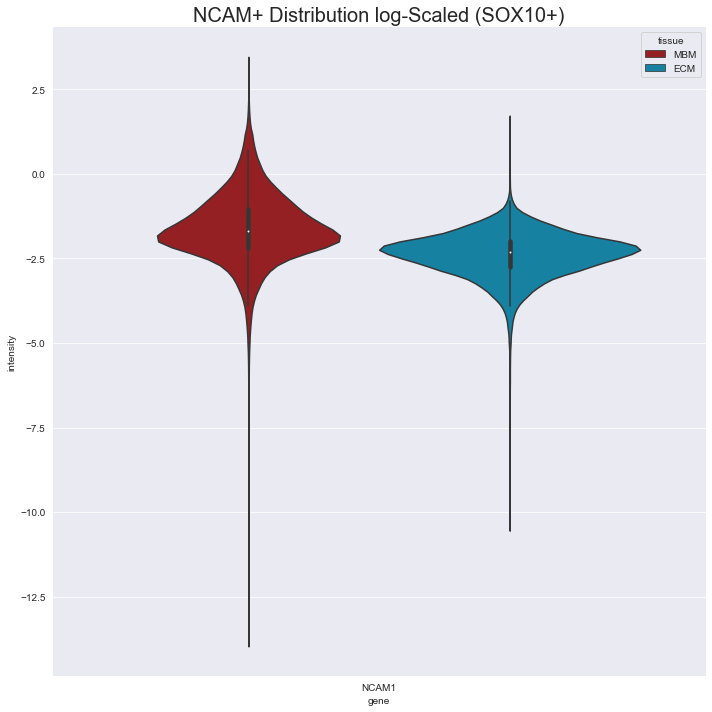

In [24]:
%%time
# Plot violin plot for raw data
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sox10_pos_log_long = sox10_pos_log.melt(id_vars=["tissue", "sample"], var_name="gene", value_name="intensity")
sns.violinplot(data=sox10_pos_log_long[sox10_pos_log_long["gene"]=="NCAM1"], x="gene", y="intensity", hue="tissue", palette=palette, ax=ax)
ax.set_title("NCAM+ Distribution log-Scaled (SOX10+)", fontsize=20)
sns.despine(left=True)

plt.tight_layout()
fig.savefig(abspath("./out/mets-violin-NCAM1-color_by_tissue-log-SOX10pos.pdf"), dpi=300)
fig.savefig(abspath("./out/mets-violin-NCAM1-color_by_tissue-log-SOX10pos.png"), dpi=300)

In [25]:
# Get total number of SOX10 positive cells by tissue
sox10_neg_log = scaled_cleaned[scaled_cleaned["SOX10"]<0]
sox10_neg_log.shape

(8332154, 4)

CPU times: total: 55.4 s
Wall time: 55.8 s


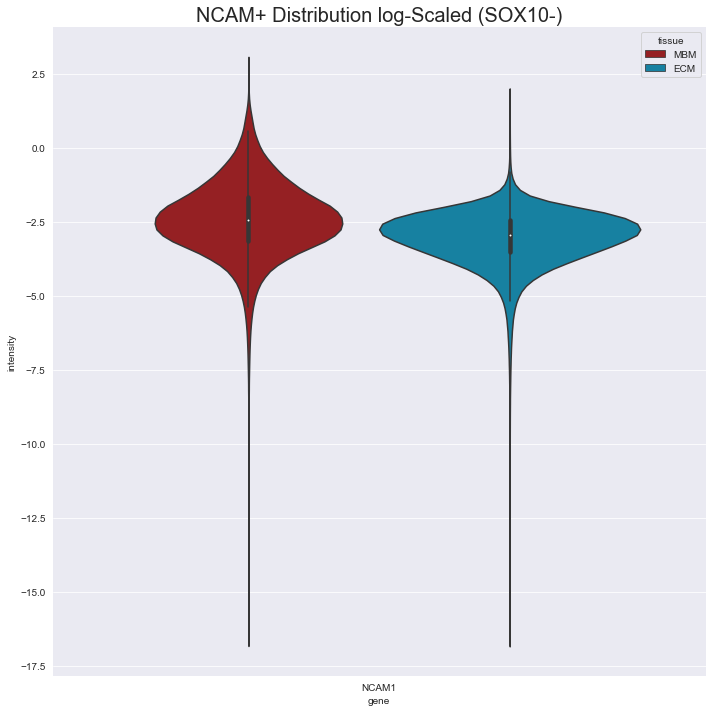

In [26]:
%%time
# Plot violin plot for raw data
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sox10_neg_log_long = sox10_neg_log.melt(id_vars=["tissue", "sample"], var_name="gene", value_name="intensity")
sns.violinplot(data=sox10_neg_log_long[sox10_neg_log_long["gene"]=="NCAM1"], x="gene", y="intensity", hue="tissue", palette=palette, ax=ax)
ax.set_title("NCAM+ Distribution log-Scaled (SOX10-)", fontsize=20)
sns.despine(left=True)

plt.tight_layout()
fig.savefig(abspath("./out/mets-violin-NCAM1-color_by_tissue-log-SOX10neg.pdf"), dpi=300)
fig.savefig(abspath("./out/mets-violin-NCAM1-color_by_tissue-log-SOX10neg.png"), dpi=300)

In [27]:
for g, df  in sox10_neg_log.groupby("tissue"):
    print(g,f'Mean = {df["NCAM1"].mean()}')
    print(g,f'Std  = {df["NCAM1"].std()}')

ECM Mean = -3.0439578427067278
ECM Std  = 0.9302818504783514
MBM Mean = -2.4038676553048974
MBM Std  = 1.2721684552984371


In [28]:
for g, df  in sox10_pos_log.groupby("tissue"):
    print(g,f'Mean = {df["NCAM1"].mean()}')
    print(g,f'Std  = {df["NCAM1"].std()}')

ECM Mean = -2.387082284243887
ECM Std  = 0.6581800978657405
MBM Mean = -1.6089846897623084
MBM Std  = 1.0257111351131694


## NCAM+SOX10+ cells per sample as fraction of all SOX10+ cells

In [29]:
# Sub setting the data
all_SOX10pos = all_images[all_images["SOX10"] >= cutoff_sox10]
all_SOX10posNCAM1pos = all_SOX10pos[all_SOX10pos["NCAM1"] >= cutoff_ncam1]

print(f"{len(all_SOX10posNCAM1pos)}/{len(all_SOX10pos)} = {len(all_SOX10posNCAM1pos)/len(all_SOX10pos):.4f}")

for g, d in all_SOX10posNCAM1pos.groupby("tissue"):
    print(f"Proportion of NCAM1+POS1+/POS+ in {g} = {len(d)/len(all_SOX10pos):.8f}")

23143/562147 = 0.0412
Proportion of NCAM1+POS1+/POS+ in ECM = 0.00005870
Proportion of NCAM1+POS1+/POS+ in MBM = 0.04111024


In [30]:
for g, d in all_SOX10posNCAM1pos.groupby("tissue"):
    print(f"Mean of SOX10 marker intensity in double positve cells in {g} = {d['SOX10'].mean():.4f}")

Mean of SOX10 marker intensity in double positve cells in ECM = 1.6391
Mean of SOX10 marker intensity in double positve cells in MBM = 1.5149


In [31]:
for g, d in all_SOX10posNCAM1pos.groupby("tissue"):
    print(f"STD of SOX10 marker intensity in double positve cells in {g} = {d['SOX10'].std():.4f}")

STD of SOX10 marker intensity in double positve cells in ECM = 0.7804
STD of SOX10 marker intensity in double positve cells in MBM = 0.6966


CPU times: total: 969 ms
Wall time: 1.01 s


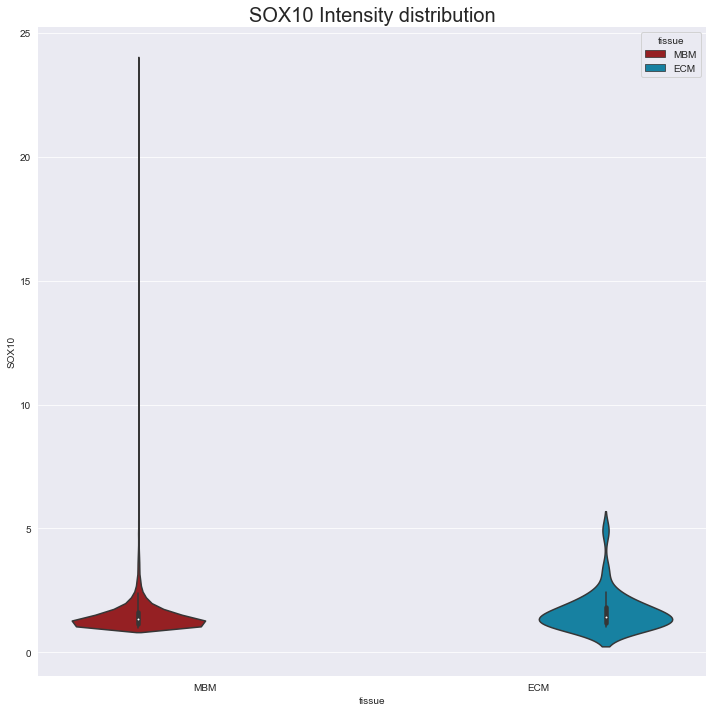

In [35]:
%%time
plot_distributions(all_SOX10posNCAM1pos, "SOX10", hue="tissue", palette=palette,
                            out=[abspath("./out/mets-violin_SOX10-by_tissue-sox10ncam1.pdf"),
                                 abspath("./out/mets-violin_SOX10-by_tissue-sox10ncam1.png")])

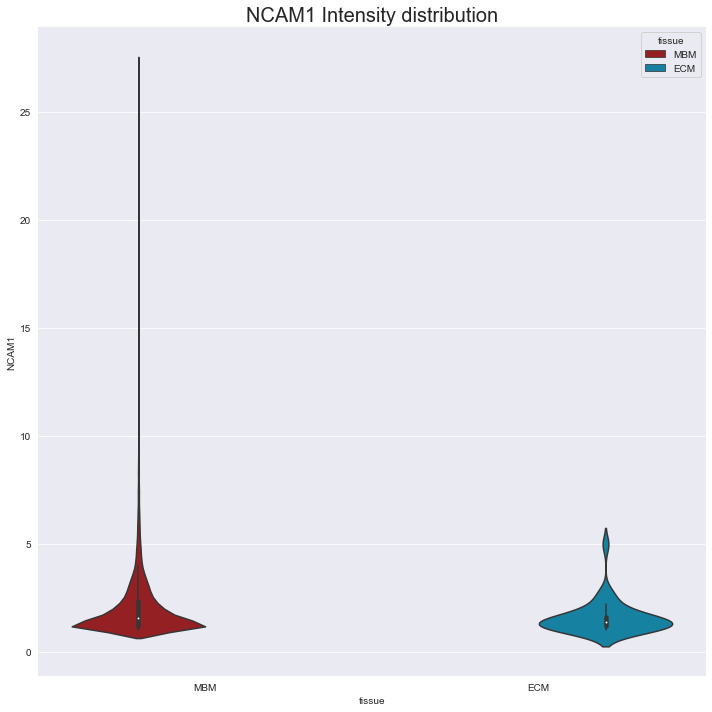

In [36]:
plot_distributions(all_SOX10posNCAM1pos, "NCAM1", hue="tissue", palette=palette,
                            out=[abspath("./out/mets-violin_NCAM1-by_tissue-sox10ncam1.pdf"),
                                 abspath("./out/mets-violin_NCAM1-by_tissue-sox10ncam1.png")])

CPU times: total: 344 ms
Wall time: 371 ms


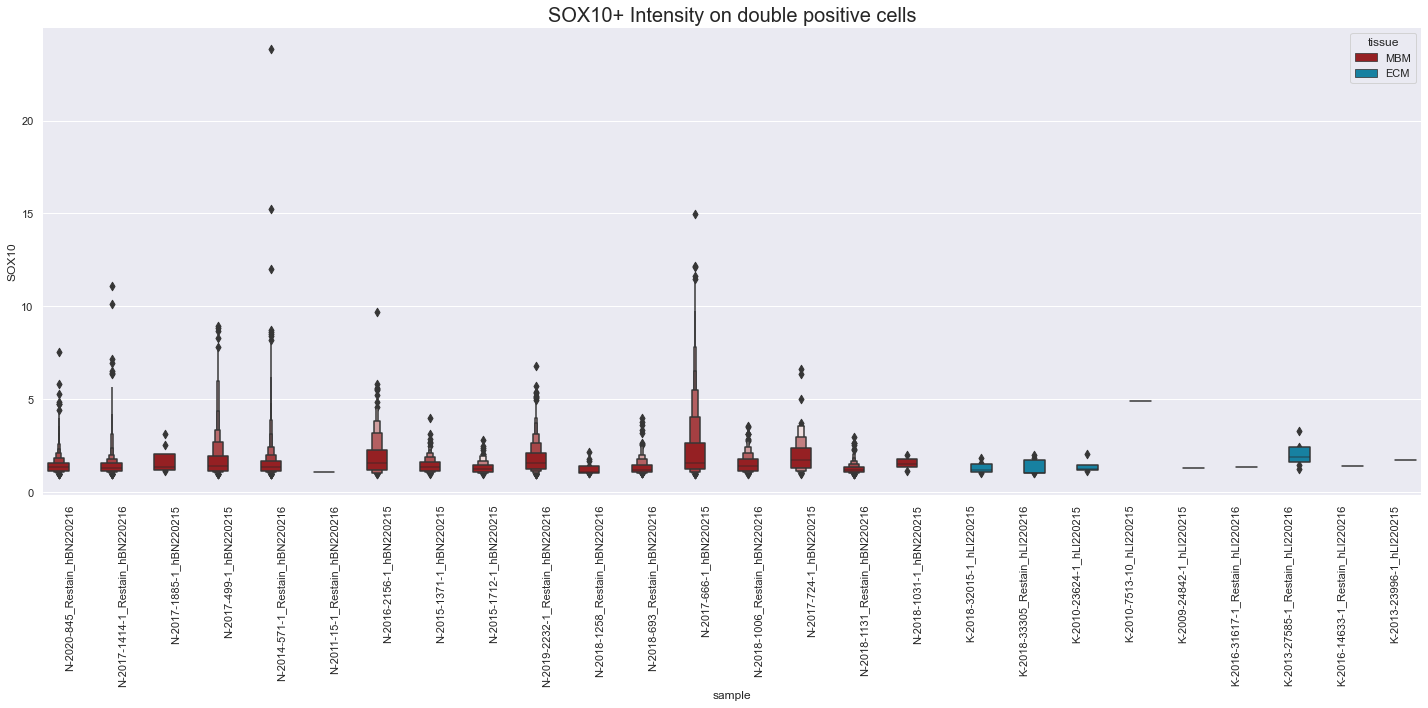

In [47]:
%%time
# Plot violin plot for raw data
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxenplot(data=all_SOX10posNCAM1pos, x="sample", y="SOX10", hue="tissue", palette=palette, ax=ax)
ax.set_title("SOX10+ Intensity on double positive cells", fontsize=20)
ax.tick_params(axis='x', labelrotation=90)
sns.despine(left=True)
plt.tight_layout()
# fig.savefig(abspath("./out/mets-violin_CD138pos_intensity-by_sample_log.pdf"), dpi=300)
# fig.savefig(abspath("./out/mets-violin_CD138pos_intensity-by_sample_log.png"), dpi=300)

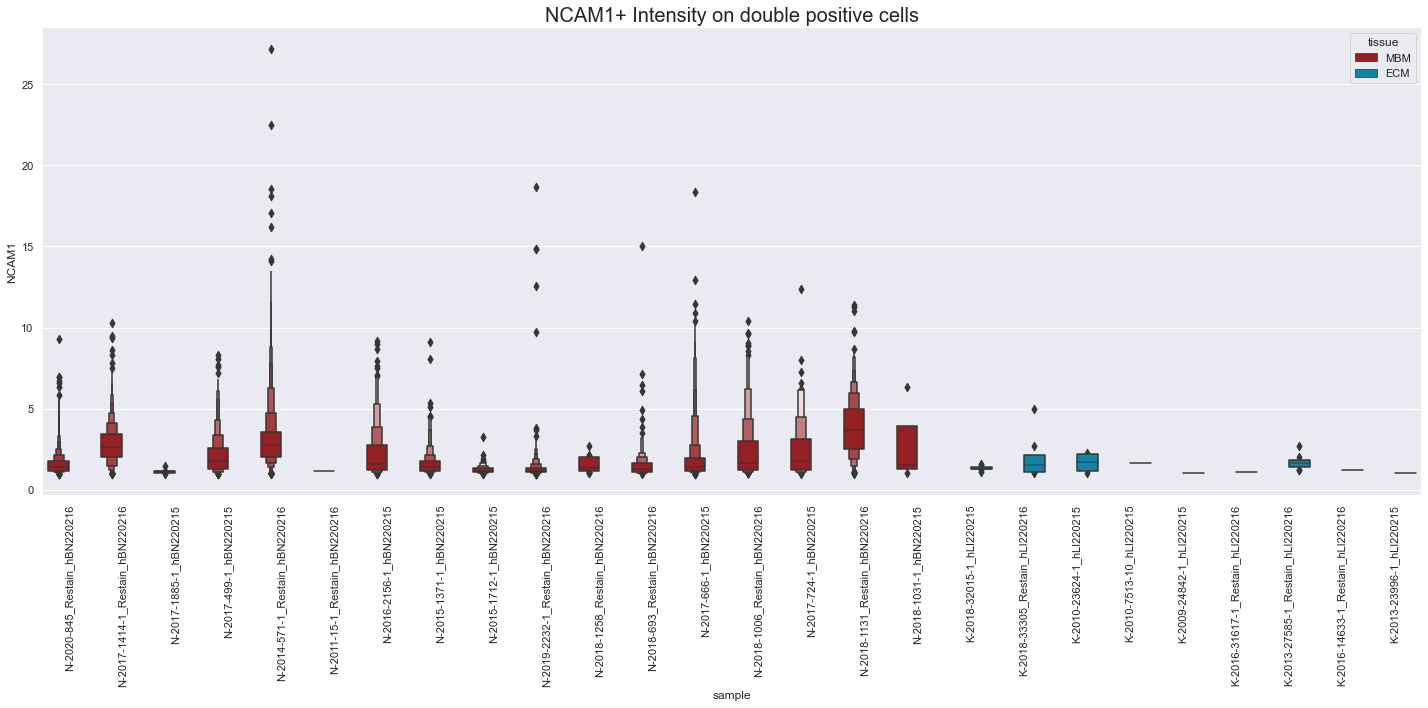

In [46]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxenplot(data=all_SOX10posNCAM1pos, x="sample", y="NCAM1", hue="tissue", palette=palette, ax=ax)
ax.set_title("NCAM1+ Intensity on double positive cells", fontsize=20)
ax.tick_params(axis='x', labelrotation=90)
sns.despine(left=True)
plt.tight_layout()

In [32]:
# Count number of cells
metadata["SOX10_positive_cell"] = get_marker_positive_cells(folder_path, "SOX10", cutoff_sox10)

# Get cell proportion to the total
metadata["SOX10_positive_cell2total"] = metadata["SOX10_positive_cell"]/metadata["n"]

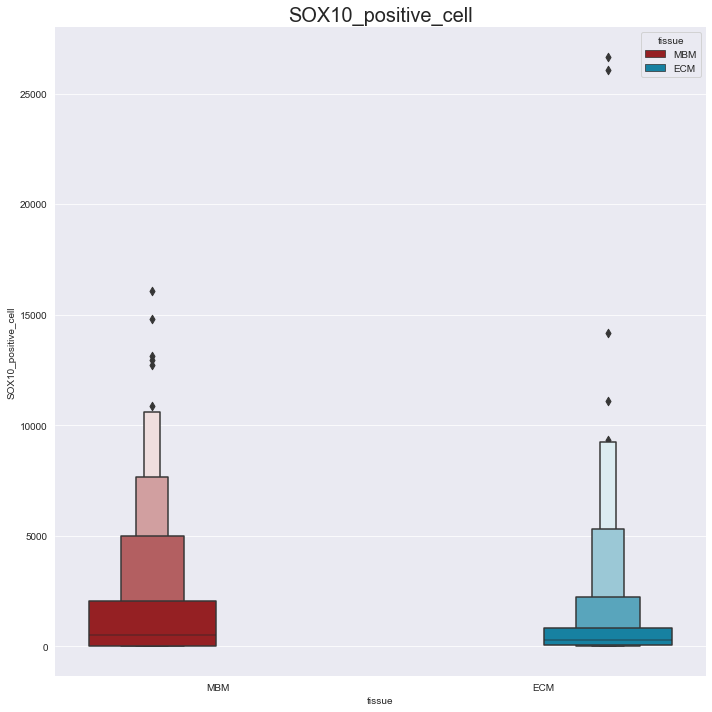

In [33]:
plot_distribution_boxen(metadata, marker="SOX10_positive_cell", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-SOX10_positive_cell.pdf"),
                             abspath("./out/mets-boxen-SOX10_positive_cell.png")])

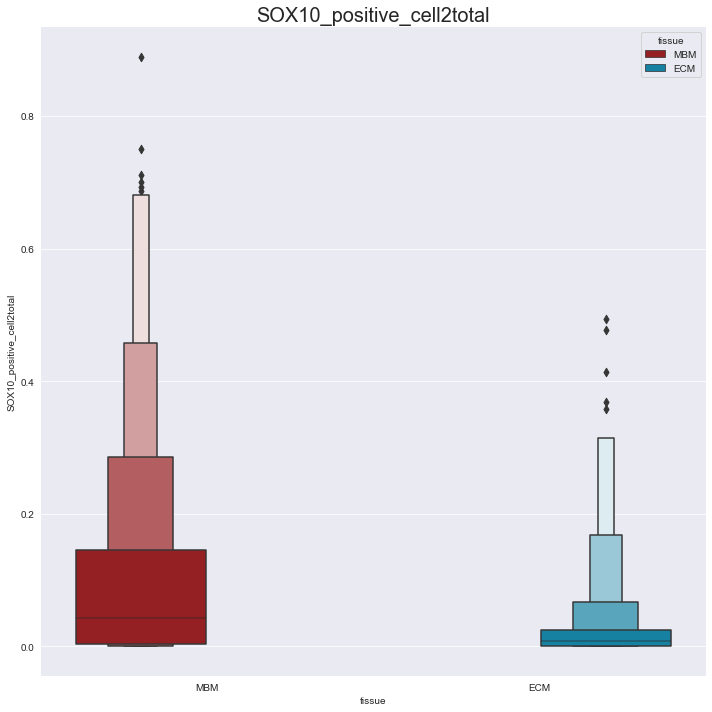

In [34]:
plot_distribution_boxen(metadata, marker="SOX10_positive_cell2total", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-SOX10_positive_cell_proportion2total.pdf"),
                             abspath("./out/mets-boxen-SOX10_positive_cell_proportion2total.png")])

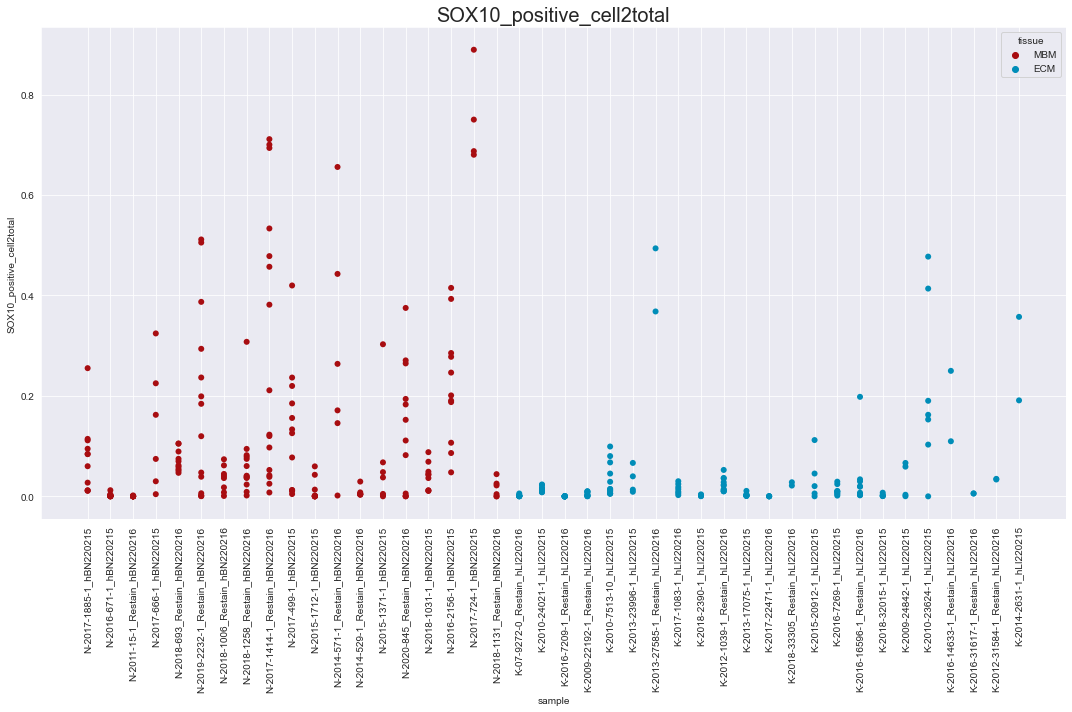

In [35]:
plot_sample_distributions(metadata, x="sample", marker="SOX10_positive_cell2total", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-SOX10_cell_proportion2total_by_sample.pdf"),
                               abspath("./out/mets-scatter-SOX10_cell_proportion2total_by_sample.png")])

In [36]:
def get_marker_double_positive_cells(path, marker, cutoff):
    # Generate a list with all the files on the folder
    files = Path(path).rglob("*.csv")

    dict = {}
    # Iterate over each file
    for f in files:

        # Read in data
        data = dt.fread(f, columns={"SOX10", "NCAM1"}).to_pandas()

        # Get positive cells
        dict[basename(f)] = len(data[(data["SOX10"]>=cutoff[0]) & ( data["NCAM1"]>=cutoff[0])])

    # Create a dataframe and output
    pos = pd.Series(dict)

    return pos
# Get double marker
metadata["NCAM1+SOX10+"] = get_marker_double_positive_cells(folder_path, marker=["NCAM1", "SOX10"], cutoff=[cutoff_sox10, cutoff_ncam1])

# Get double marker proportion to total
metadata["NCAM1+SOX10+_proportion2total"] = metadata["NCAM1+SOX10+"]/metadata["n"]

# Get double marker proportion to SOX10+
metadata["NCAM1+SOX10+_proportion2SOX10+"] = metadata["NCAM1+SOX10+"]/metadata["SOX10_positive_cell"]
metadata.head()

,sample,source,n,tissue,SOX10_positive_cell,SOX10_positive_cell2total,NCAM1+SOX10+,NCAM1+SOX10+_proportion2total,NCAM1+SOX10+_proportion2SOX10+
file,,,,,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,213,0.011737,0,0.000000,0.000000
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,2,0.000120,0,0.000000,0.000000
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,0,0.000000,0,0.000000,NaN
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,1363,0.029973,3,0.000066,0.002201
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,913,0.069855,84,0.006427,0.092004


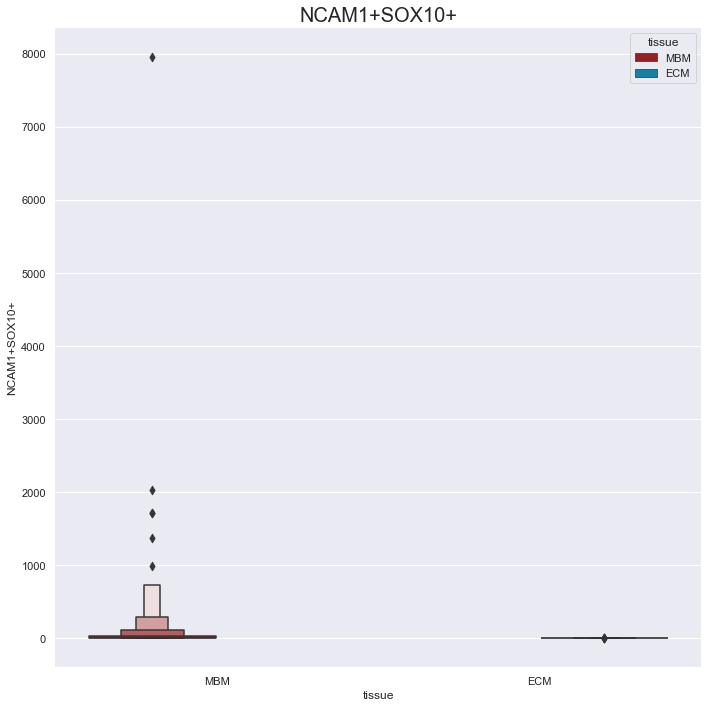

In [106]:
plot_distribution_boxen(metadata, marker="NCAM1+SOX10+", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-SOX10posNCAM1pos_cell.pdf"),
                             abspath("./out/mets-boxen-SOX10posNCAM1pos_cell.pdf")])

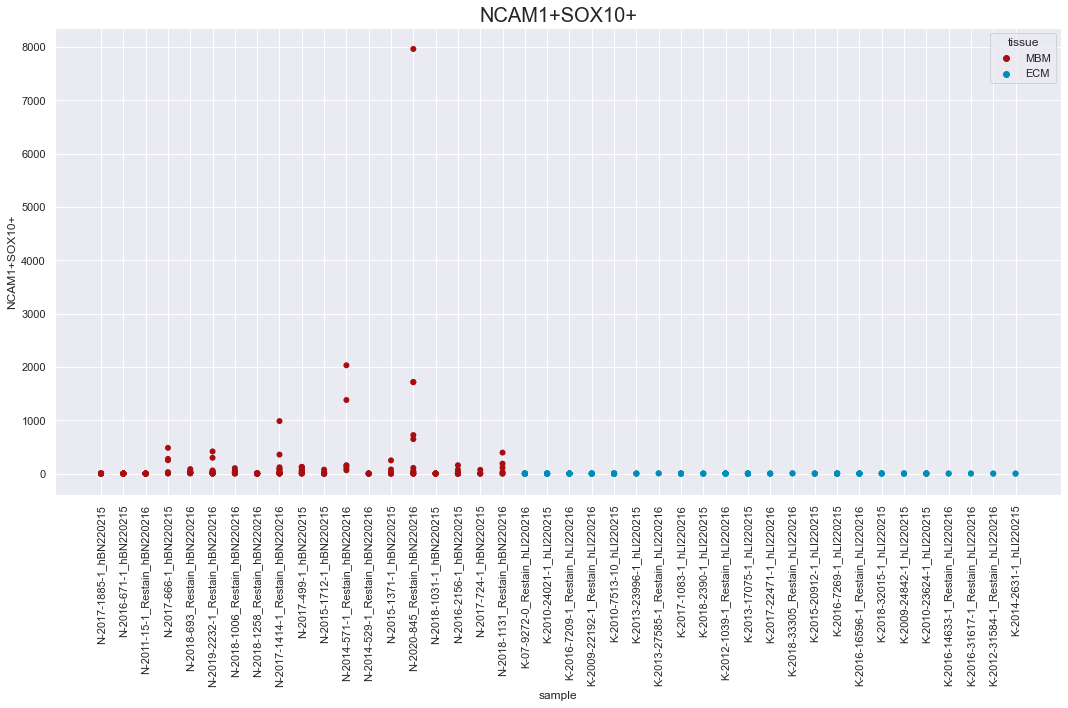

In [107]:
plot_sample_distributions(metadata, x="sample", marker="NCAM1+SOX10+", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-SOX10posNCAM1pos_cell_by_sample.pdf"),
                               abspath("./out/mets-scatter-SOX10posNCAM1pos_cell_by_sample.png")])

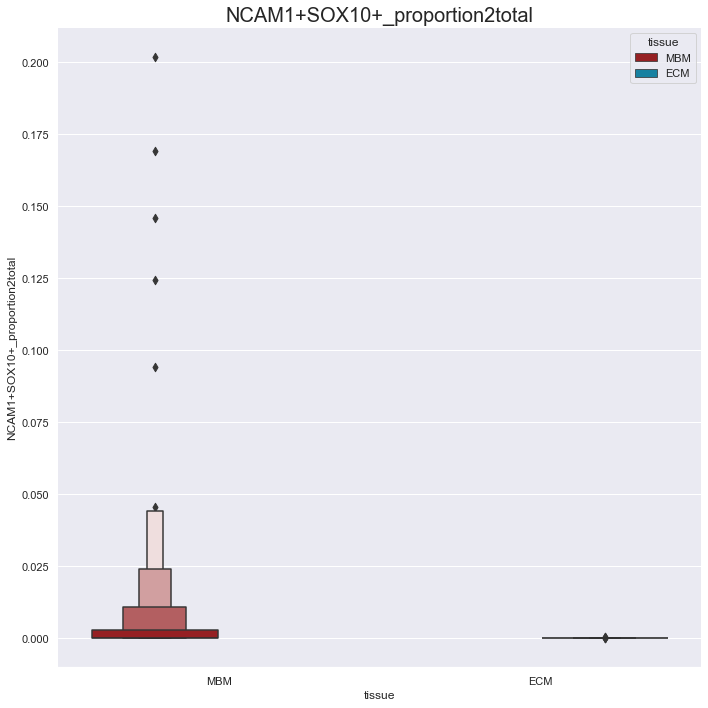

In [108]:
plot_distribution_boxen(metadata, marker="NCAM1+SOX10+_proportion2total", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-SOX10posNCAM1pos_cell_proportion2total.pdf"),
                             abspath("./out/mets-boxen-SOX10posNCAM1pos_cell_proportion2total.png")])

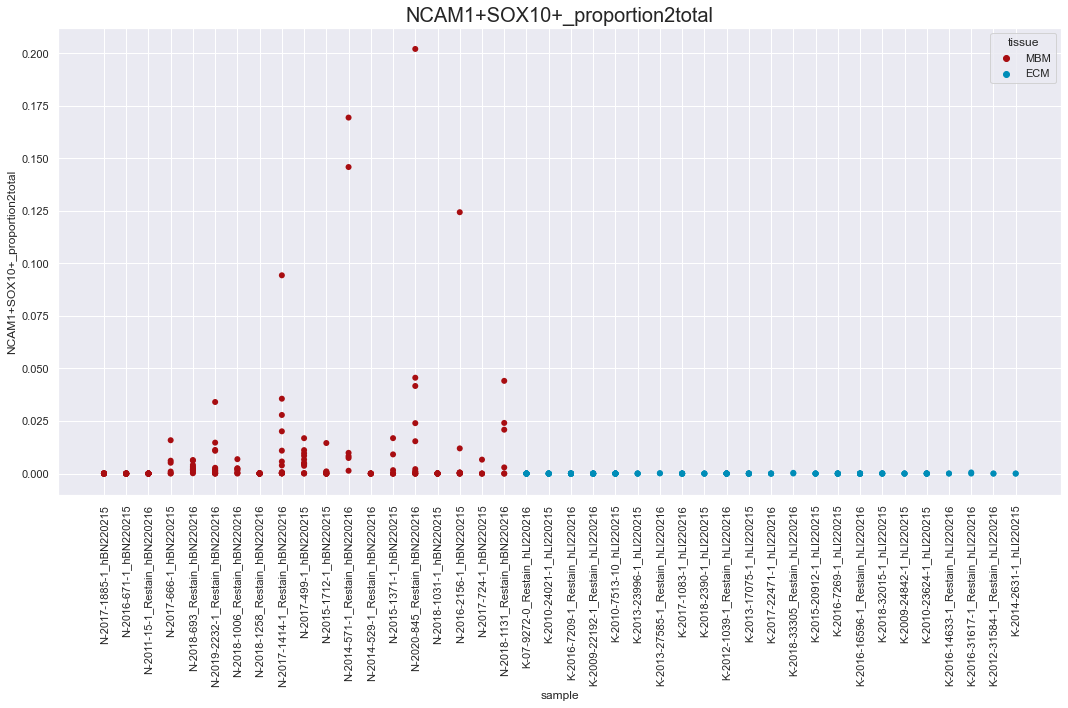

In [109]:
plot_sample_distributions(metadata, x="sample", marker="NCAM1+SOX10+_proportion2total", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-SOX10posNCAM1pos_cell_proportion2total_by_sample.pdf"),
                               abspath("./out/mets-scatter-SOX10posNCAM1pos_cell_proportion2total_by_sample.png")])

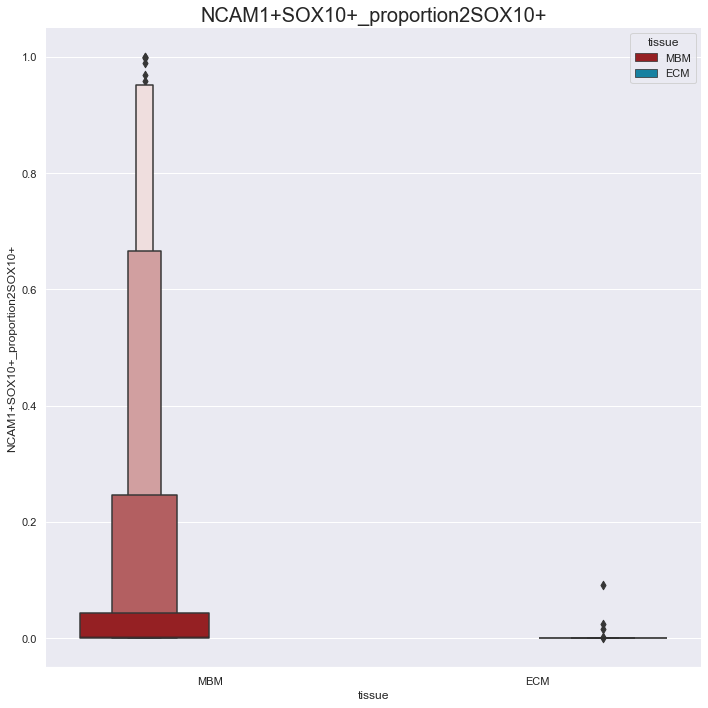

In [110]:
plot_distribution_boxen(metadata, marker="NCAM1+SOX10+_proportion2SOX10+", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-SOX10posNCAM1pos_cell_proportion2SOX10pos.pdf"),
                             abspath("./out/mets-boxen-SOX10posNCAM1pos_cell_proportion2SOX10pos.png")])

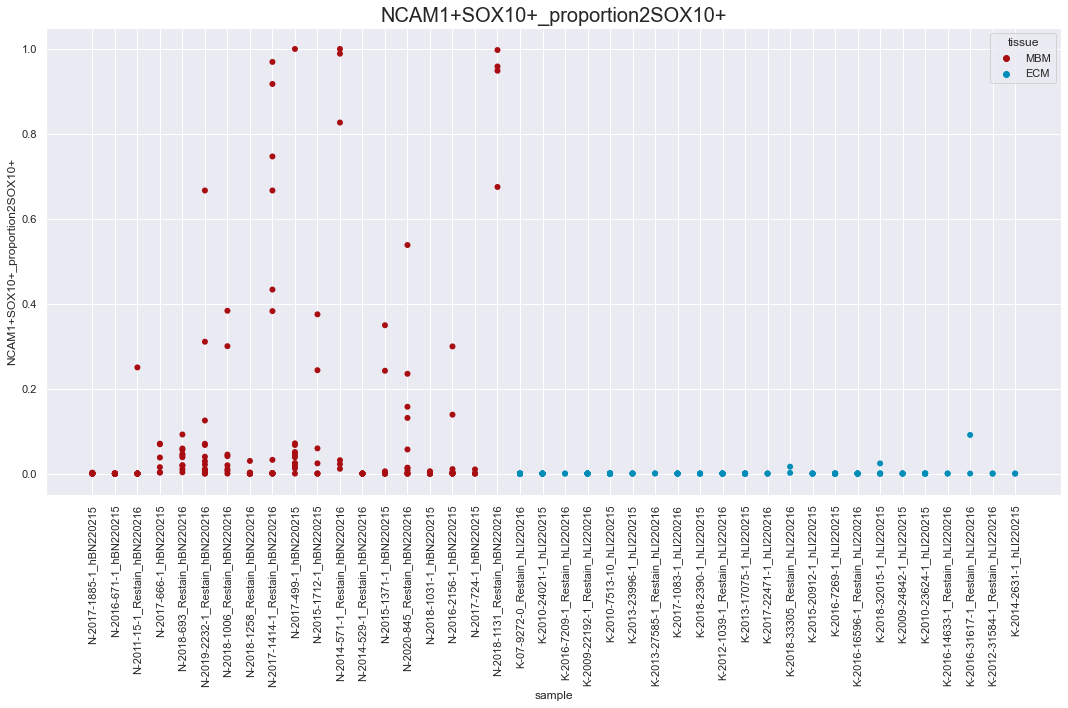

In [111]:
plot_sample_distributions(metadata, x="sample", marker="NCAM1+SOX10+_proportion2SOX10+", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-SOX10posNCAM1pos_cell_proportion2SOX10pos_by_sample.pdf"),
                               abspath("./out/mets-scatter-SOX10posNCAM1pos_cell_proportion2SOX10pos_by_sample.png")])

In [38]:
# Test if the proportion of NCAM1+SOX10+/SOX10+ is differente
res_NCAM1pos_SOX10pos = ranksums(metadata[metadata["tissue"]=="MBM"]["NCAM1+SOX10+_proportion2SOX10+"], metadata[metadata["tissue"]=="ECM"]["NCAM1+SOX10+_proportion2SOX10+"])
res_NCAM1pos_SOX10pos

RanksumsResult(statistic=6.972639085179927, pvalue=3.1104988555920635e-12)

## NCAM1 in SOX10+ cells --> log scale graph + stats

In [129]:
# Getting SOX10+ cells
sox10pos = all_images[all_images["SOX10"]>=1]
sox10pos_log = scaled_cleaned[scaled_cleaned["SOX10"]>=0]

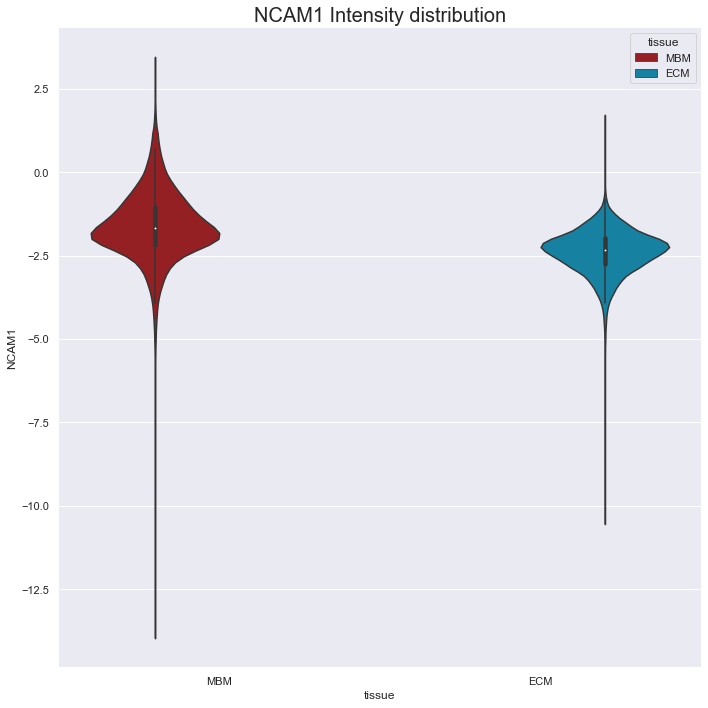

In [134]:
plot_distributions(sox10pos_log, marker="NCAM1", hue="tissue", palette=palette,
                   out=[abspath("./out/mets-violin_NCAM1_intensity-by_tissue-log_SOX10pos.pdf"),
                        abspath("./out/mets-violin_NCAM1_intensity-by_tissue-log_SOX10pos.png")])

In [130]:
res_NCAM1_SOX10pos = ranksums(sox10pos[sox10pos["tissue"]=="MBM"]["NCAM1"], sox10pos[sox10pos["tissue"]=="ECM"]["NCAM1"])
res_NCAM1_SOX10pos

RanksumsResult(statistic=316.56126078279027, pvalue=0.0)

In [131]:
len(sox10pos)

562147

In [135]:
#
for g, d in sox10pos.groupby("tissue"):
    print(f"Mean NCAM1 intensity value in {g} = {d['NCAM1'].mean():.4f}")

Mean NCAM1 intensity value in ECM = 0.1113
Mean NCAM1 intensity value in MBM = 0.3521


In [133]:
np.log2(0.3521/0.1113)

1.661531634521172